In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import math

## Problem 1: KNN with built-in package

Problem 1: KNN with normalized features
k =  75 -> Accuracy = 0.6686
k =  77 -> Accuracy = 0.6657
k =  79 -> Accuracy = 0.6686
k =  81 -> Accuracy = 0.6657
k =  83 -> Accuracy = 0.6628
k =  85 -> Accuracy = 0.6657
k =  87 -> Accuracy = 0.6657
k =  89 -> Accuracy = 0.6657
k =  91 -> Accuracy = 0.6657
k =  93 -> Accuracy = 0.6541
k =  95 -> Accuracy = 0.6599
k =  97 -> Accuracy = 0.6628
k =  99 -> Accuracy = 0.6686
k = 101 -> Accuracy = 0.6715
k = 103 -> Accuracy = 0.6773
k = 105 -> Accuracy = 0.6686

Accuracy Table for Problem 1:
      k  accuracy
0    75  0.668605
1    77  0.665698
2    79  0.668605
3    81  0.665698
4    83  0.662791
5    85  0.665698
6    87  0.665698
7    89  0.665698
8    91  0.665698
9    93  0.654070
10   95  0.659884
11   97  0.662791
12   99  0.668605
13  101  0.671512
14  103  0.677326
15  105  0.668605


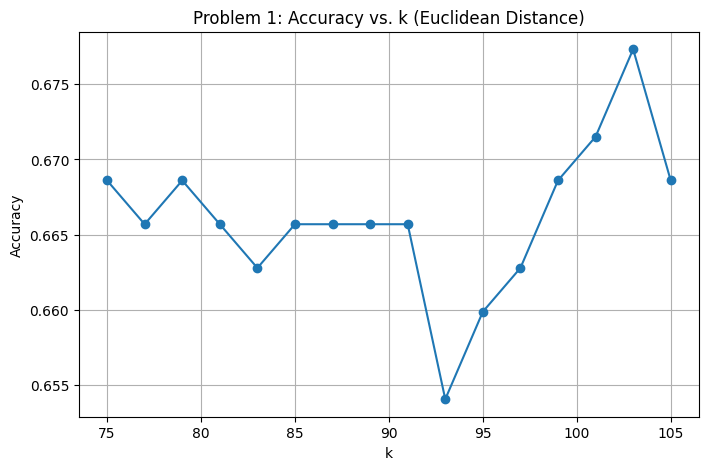

Best k for Problem 1 is 103 with accuracy 0.6773


In [ ]:
# Read training and test data
train_df = pd.read_csv('healthcareTrain.csv')
test_df  = pd.read_csv('healthcareTest.csv')

# Define features and target (using features described in problem 1)
features_p1 = ['pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost', 'adjust_total_30d', 'num_er']
target = 'pdc_80_flag'

# Create training and test sets for Problem 1
X_train_p1 = train_df[features_p1].copy()
y_train = train_df[target].copy()
X_test_p1 = test_df[features_p1].copy()
y_test = test_df[target].copy()

# Create a pipeline: first normalize with MinMaxScaler, then apply KNN classifier.
# We will loop over different values of k.
k_values = list(range(75, 106, 2))
accuracy_list_p1 = []

print("Problem 1: KNN with normalized features")
for k in k_values:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean'))
    ])

    pipeline.fit(X_train_p1, y_train)
    y_pred = pipeline.predict(X_test_p1)
    acc = accuracy_score(y_test, y_pred)
    accuracy_list_p1.append(acc)
    print(f"k = {k:3d} -> Accuracy = {acc:.4f}")

# Report accuracy in a table (print as DataFrame)
table_p1 = pd.DataFrame({'k': k_values, 'accuracy': accuracy_list_p1})
print("\nAccuracy Table for Problem 1:")
print(table_p1)

# Plot accuracy vs. k
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracy_list_p1, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Problem 1: Accuracy vs. k (Euclidean Distance)')
plt.grid(True)
plt.show()

# Determine best k:
best_index_p1 = np.argmax(accuracy_list_p1)
best_k_p1 = k_values[best_index_p1]
print(f"Best k for Problem 1 is {best_k_p1} with accuracy {accuracy_list_p1[best_index_p1]:.4f}")

## Problem 2: KNN with Value Distance Metric (VDM) for 'region'

In [ ]:
# We will use the same numeric features as before plus the categorical "region".
# For training and test, we separate numeric and categorical features.
numeric_features = features_p1  # same as before
categorical_feature = 'regionN'

# Note: the description says that region is coded as:
#   1 = Northeast, 2 = Midwest, 3 = South, 4 = West
# For easier interpretation we can map these codes to strings if desired.
region_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
train_df['region_cat'] = train_df[categorical_feature].map(region_mapping)
test_df['region_cat']  = test_df[categorical_feature].map(region_mapping)

# We now compute the conditional probabilities for the region variable relative to the target.
# That is, for each region value (e.g., 'Northeast') compute:
#    P(pdc-80-flag = 1 | region) and P(pdc-80-flag = 0 | region)

region_vals = train_df['region_cat'].unique()
cond_probs = {}  # dictionary to hold probabilities: cond_probs[region][class] = probability

for region in region_vals:
    subset = train_df[train_df['region_cat'] == region]
    total = len(subset)
    prob_1 = np.sum(subset[target] == 1) / total
    prob_0 = np.sum(subset[target] == 0) / total
    cond_probs[region] = {0: prob_0, 1: prob_1}

# Report the conditional probabilities in a table:
print("\nConditional probabilities for region given class (pdc-80-flag):")
cond_prob_df = pd.DataFrame.from_dict({region: cond_probs[region] for region in cond_probs},
                                        orient='index')
cond_prob_df.index.name = 'Region'
cond_prob_df.rename(columns={0: 'P(flag=0)', 1: 'P(flag=1)'}, inplace=True)
print(cond_prob_df)


Conditional probabilities for region given class (pdc-80-flag):
           P(flag=0)  P(flag=1)
Region                         
Midwest     0.568579   0.431421
South       0.645995   0.354005
West        0.576087   0.423913
Northeast   0.495495   0.504505


In [ ]:
# Next, compute the VDM distances between every pair of regions.
# The VDM distance between two categorical values a and b is defined as:
#     d(a, b) = sum_over_classes | P(class|a) - P(class|b) |
# (Note: sometimes squared differences are used; here we use the absolute difference.)
def vdm_distance(val_a, val_b):
    # Both are region strings.
    prob_a = cond_probs[val_a]
    prob_b = cond_probs[val_b]
    distance = 0.0
    # Iterate over all class labels present in the conditional probability dictionary
    for cls in prob_a.keys():
        distance += (prob_a[cls] - prob_b[cls])**2
    return distance

# Compute distances between each pair of regions:
regions = list(cond_probs.keys())
vdm_matrix = pd.DataFrame(index=regions, columns=regions)
for r1 in regions:
    print(f"Computing distances for region {r1}")
    for r2 in regions:
        print(f"to region {r2}")
        vdm_matrix.loc[r1, r2] = vdm_distance(r1, r2)
print("\nVDM distances between regions:")
print(vdm_matrix)

Computing distances for region Midwest
to region Midwest
to region South
to region West
to region Northeast
Computing distances for region South
to region Midwest
to region South
to region West
to region Northeast
Computing distances for region West
to region Midwest
to region South
to region West
to region Northeast
Computing distances for region Northeast
to region Midwest
to region South
to region West
to region Northeast

VDM distances between regions:
            Midwest     South      West Northeast
Midwest         0.0  0.011987  0.000113  0.010682
South      0.011987       0.0  0.009774    0.0453
West       0.000113  0.009774       0.0   0.01299
Northeast  0.010682    0.0453   0.01299       0.0


In [ ]:
# Getting the numeric features
x_train_numeric = train_df[numeric_features].values
x_test_numeric = test_df[numeric_features].values

In [ ]:
# Now we implement a custom KNN that uses:
#   - Euclidean distance on the numeric features (normalized using training min and max)
#   - VDM for the categorical feature (region)
#
# The overall distance between two points x and y will be:
#    d(x,y) = EuclideanDistance(x_numeric, y_numeric) + vdm_distance(x_region, y_region)
#
# We must use the training parameters (min and max) for numeric normalization.

# Calculate min and max for each numeric feature in the training data
train_min_vals = train_df[numeric_features].min(axis=0)
train_max_vals = train_df[numeric_features].max(axis=0)
# test_min_vals = test_df[numeric_features].min(axis=0)
# test_max_vals = test_df[numeric_features].max(axis=0)

# # Apply Min-Max scaling to the training data
# X_train_num = (train_df[numeric_features] - train_min_vals) / (train_max_vals - train_min_vals)

# # Apply the same scaling to the test data using the min and max from the training data
# X_test_num = (test_df[numeric_features] - train_min_vals) / (train_max_vals - train_min_vals)

# Apply Min-Max scaling to the training data
# X_train_num = (train_df[numeric_features] - train_min_vals) / (train_max_vals - train_min_vals)

# # Apply the same scaling to the test data using the min and max from the training data
# X_test_num = (test_df[numeric_features] - test_min_vals) / (test_max_vals - test_min_vals)

# Apply Min-Max scaling to the training data
X_train_num = (x_train_numeric - x_train_numeric.min()) / (x_train_numeric.max() - x_train_numeric.min())

# Apply the same scaling to the test data using the min and max from the training data
X_test_num = (x_test_numeric - x_train_numeric.min()) / (x_train_numeric.max() - x_train_numeric.min())

# Convert to numpy arrays if needed
X_train_num = np.array(X_train_num)
X_test_num = np.array(X_test_num)

# We now extract the region as a string from training and test.
X_train_cat = train_df['region_cat'].values  # training categorical
X_test_cat  = test_df['region_cat'].values   # test categorical

# We also have the target values as before.
y_train = train_df[target].values
y_test  = test_df[target].values

In [ ]:
# Define a custom distance function between a test point and a training point.
def custom_distance(test_point_num, test_point_cat, train_point_num, train_point_cat):
    # Euclidean distance for numeric features:
    d_num = np.sum((train_point_num - test_point_num)**2)
    # VDM distance for categorical:
    d_cat = vdm_distance(test_point_cat, train_point_cat)
    # print('VDM distance:',d_cat)
    return np.sqrt(d_num + d_cat)

# Now we implement a function to perform KNN classification using our custom distance.
def custom_knn_predict(test_nums, test_cats, train_nums, train_cats, y_train, k):
    predictions = []
    for i in range(len(test_nums)):
        distances = []
        for j in range(len(train_nums)):
            d = custom_distance(test_nums[i], test_cats[i], train_nums[j], train_cats[j])
            distances.append(d)
        # Get indices of k nearest neighbors
        knn_idx = np.argsort(distances)[:k]
        # Majority vote (if tie, choose the smaller label)
        neighbor_labels = y_train[knn_idx]
        # Count frequencies:
        vals, counts = np.unique(neighbor_labels, return_counts=True)
        prediction = vals[np.argmax(counts)]
        predictions.append(prediction)
    return np.array(predictions)

In [ ]:
# Evaluate our custom KNN for k = 75 to 105 (step 2)
k_values = list(range(75, 106, 2))
accuracy_list_p2 = []

print("\nEvaluating custom KNN with VDM (including region) for various k:")
for k in k_values:
    y_pred_custom = custom_knn_predict(X_test_num, X_test_cat, X_train_num, X_train_cat, y_train, k)
    acc = accuracy_score(y_test, y_pred_custom)
    accuracy_list_p2.append(acc)
    print(f"k = {k:3d} -> Accuracy = {acc:.4f}")

table_p2 = pd.DataFrame({'k': k_values, 'accuracy': accuracy_list_p2})
print("\nAccuracy Table for Problem 2 (custom VDM):")
print(table_p2)

# Compare mean accuracy of Problem 2 with Problem 1.
mean_acc_p1 = np.mean(accuracy_list_p1)
mean_acc_p2 = np.mean(accuracy_list_p2)
print(f"\nMean accuracy Problem 1: {mean_acc_p1:.4f}")
print(f"Mean accuracy Problem 2: {mean_acc_p2:.4f}")
if mean_acc_p2 > mean_acc_p1:
    print("Including region with VDM improved the accuracy.")
else:
    print("Including region with VDM did NOT improve the accuracy.")


Evaluating custom KNN with VDM (including region) for various k:
k =  75 -> Accuracy = 0.6483
k =  77 -> Accuracy = 0.6366
k =  79 -> Accuracy = 0.6453
k =  81 -> Accuracy = 0.6395
k =  83 -> Accuracy = 0.6424
k =  85 -> Accuracy = 0.6424
k =  87 -> Accuracy = 0.6366
k =  89 -> Accuracy = 0.6395
k =  91 -> Accuracy = 0.6395
k =  93 -> Accuracy = 0.6366
k =  95 -> Accuracy = 0.6250
k =  97 -> Accuracy = 0.6337
k =  99 -> Accuracy = 0.6483
k = 101 -> Accuracy = 0.6308
k = 103 -> Accuracy = 0.6308
k = 105 -> Accuracy = 0.6279

Accuracy Table for Problem 2 (custom VDM):
      k  accuracy
0    75  0.648256
1    77  0.636628
2    79  0.645349
3    81  0.639535
4    83  0.642442
5    85  0.642442
6    87  0.636628
7    89  0.639535
8    91  0.639535
9    93  0.636628
10   95  0.625000
11   97  0.633721
12   99  0.648256
13  101  0.630814
14  103  0.630814
15  105  0.627907

Mean accuracy Problem 1: 0.6661
Mean accuracy Problem 2: 0.6377
Including region with VDM did NOT improve the accuracy.

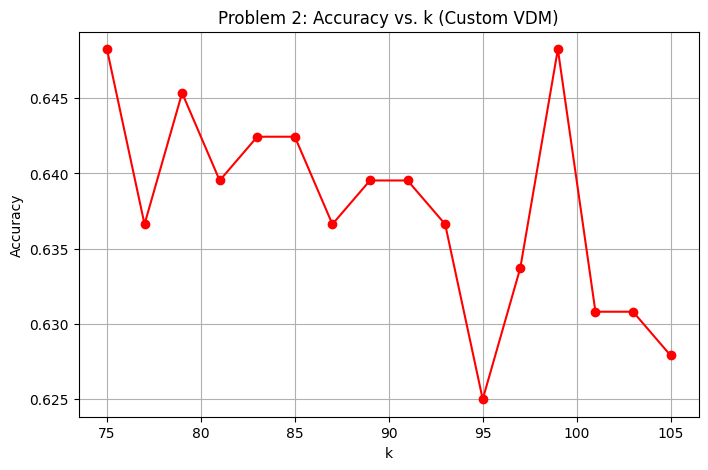

In [ ]:
# Plot accuracy vs. k for Problem 2:
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracy_list_p2, marker='o', color='red')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Problem 2: Accuracy vs. k (Custom VDM)')
plt.grid(True)
plt.show()

In [ ]:
# Determine best k for Problem 2:
best_index_p2 = np.argmax(accuracy_list_p2)
best_k_p2 = k_values[best_index_p2]
print(f"Best k for Problem 2 is {best_k_p2} with accuracy {accuracy_list_p2[best_index_p2]:.4f}")

# Finally, print predictions for 100th, 200th, and 300th test points using best model.
# (Indices 99, 199, 299 assuming test set has at least 300 examples.)
y_pred_best = custom_knn_predict(X_test_num, X_test_cat, X_train_num, X_train_cat, y_train, best_k_p2)
indices_to_report = [99, 199, 299]
print("\nPredictions for test points #100, #200, and #300 using best model (Problem 2):")
for idx in indices_to_report:
    print(f"Test point {idx+1}: Predicted pdc-80-flag = {y_pred_best[idx]}")

Best k for Problem 2 is 75 with accuracy 0.6483

Predictions for test points #100, #200, and #300 using best model (Problem 2):
Test point 100: Predicted pdc-80-flag = 0
Test point 200: Predicted pdc-80-flag = 0
Test point 300: Predicted pdc-80-flag = 0


## Problem 3: Minimization of f(x) = x² + 6x

In [ ]:
# 1. Analytic solution using derivative
# f(x)=x^2+6x => f'(x)=2x+6. Set derivative to 0: 2x+6=0 => x=-3.
x_min_analytic = -3
print(f"Analytic solution: x = {x_min_analytic}")

Analytic solution: x = -3


In [ ]:
# 2. Gradient descent to minimize f(x)
def f(x):
    return x**2 + 6*x

def grad_f(x):
    return 2*x + 6

# Parameters for gradient descent:
learning_rate = 0.1
tolerance = 1e-6
max_iter = 1000

# Start at some initial value, e.g. x0 = 0.
x_current = 0.0
history = [x_current]

for i in range(max_iter):
    grad = grad_f(x_current)
    x_next = x_current - learning_rate * grad
    history.append(x_next)
    if abs(x_next - x_current) < tolerance:
        break
    x_current = x_next

print(f"Gradient descent solution: x = {x_current} (in {i+1} iterations)")
print(f"f(x) = {f(x_current)}")

Gradient descent solution: x = -2.999995402513377 (in 61 iterations)
f(x) = -8.999999999978861


Both methods give x ~ -3 (analytic x = -3)



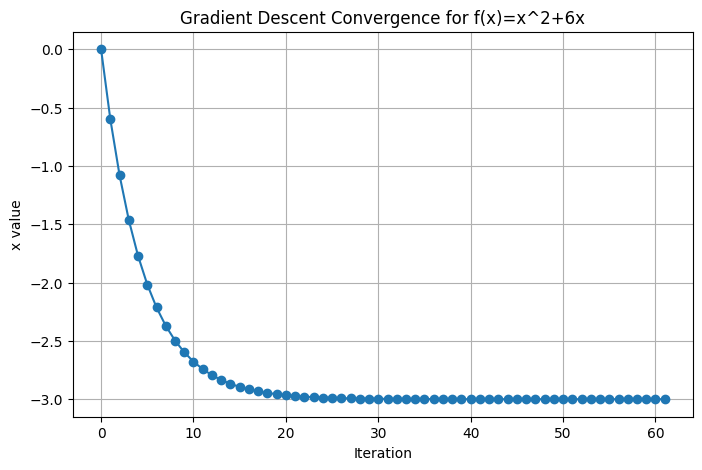

In [ ]:
# Optionally, plot the convergence:
plt.figure(figsize=(8,5))
plt.plot(history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.title('Gradient Descent Convergence for f(x)=x^2+6x')
plt.grid(True)
plt.show()

## Problem 4: Logistic Regression on Challenger O-Ring Data

In [2]:
# Read the data file (Oring.csv). Assume it contains at least two columns:
#   "LaunchTemperature" and "OringFailure" (where OringFailure is 0 or 1)
oring_df = pd.read_csv('ORing.csv')

# Inspect the data columns; adjust names if necessary.
# For this example, we assume:
#   - Temperature column is named "LaunchTemperature"
#   - Failure indicator is named "OringFailure"
# If the names differ, change accordingly.

# 1. Normalize the launch temperature using x_norm = (x - mu) / sigma.
temp = oring_df['Temp'].values
mu_temp = np.mean(temp)
sigma_temp = np.std(temp)
oring_df['TempNormalized'] = (temp - mu_temp) / sigma_temp
print(f"Normalized Launch Temperature: mu = {mu_temp:.4f}, sigma = {sigma_temp:.4f}")

Normalized Launch Temperature: mu = 69.9167, sigma = 7.2222


In [3]:
# 2. Create logistic regression model using gradient descent (no built-ins)
# Logistic regression model: P(y=1|x) = 1/(1+exp(-z)) with z = theta0 + theta1*x.
# Loss function is the log-loss. We compute gradients and update parameters.
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
# Prepare data:
X = oring_df['TempNormalized'].values.reshape(-1, 1)  # feature
y = oring_df['Failure'].values  # target
X

array([[-2.34232502],
       [-1.92693733],
       [-1.78847477],
       [-0.95769939],
       [-0.5423117 ],
       [-0.40384914],
       [-0.40384914],
       [-0.40384914],
       [-0.26538658],
       [-0.12692402],
       [ 0.01153855],
       [ 0.01153855],
       [ 0.01153855],
       [ 0.01153855],
       [ 0.28846367],
       [ 0.42692623],
       [ 0.70385136],
       [ 0.70385136],
       [ 0.84231392],
       [ 0.84231392],
       [ 1.11923905],
       [ 1.25770161],
       [ 1.39616417],
       [ 1.53462674]])

In [6]:
# Add a column of ones for the intercept:
X_design = np.hstack([np.ones((X.shape[0], 1)), X])
X_design

array([[ 1.        , -2.34232502],
       [ 1.        , -1.92693733],
       [ 1.        , -1.78847477],
       [ 1.        , -0.95769939],
       [ 1.        , -0.5423117 ],
       [ 1.        , -0.40384914],
       [ 1.        , -0.40384914],
       [ 1.        , -0.40384914],
       [ 1.        , -0.26538658],
       [ 1.        , -0.12692402],
       [ 1.        ,  0.01153855],
       [ 1.        ,  0.01153855],
       [ 1.        ,  0.01153855],
       [ 1.        ,  0.01153855],
       [ 1.        ,  0.28846367],
       [ 1.        ,  0.42692623],
       [ 1.        ,  0.70385136],
       [ 1.        ,  0.70385136],
       [ 1.        ,  0.84231392],
       [ 1.        ,  0.84231392],
       [ 1.        ,  1.11923905],
       [ 1.        ,  1.25770161],
       [ 1.        ,  1.39616417],
       [ 1.        ,  1.53462674]])

In [8]:
# Initialize parameters:
theta = np.zeros(X_design.shape[1])  # theta0 and theta1
theta

array([0., 0.])

In [15]:
# Gradient descent parameters:
learning_rate = 0.1
max_iter = 10000
tolerance = 1e-6


z = X_design.dot(theta)
predictions = sigmoid(z)

# Gradient descent loop:
for iteration in range(max_iter):
    # Gradient: X^T * (predictions - y) / n
    gradient = (X_design.T.dot(predictions - y)) / len(y)
    theta_new = theta - learning_rate * gradient
    if np.linalg.norm(theta_new - theta, ord=1) < tolerance:
        theta = theta_new
        break
    theta = theta_new

print("\nLogistic Regression Model (Problem 4):")
print(f"theta0 = {theta[0]:.4f},theta1 = {theta[1]:.4f}")
print("The logistic model is:")
print("   P(O-ring failure=1 | x) = 1 / (1 + exp(- (theta0 + theta1 * x_norm)))")
print("where x_norm = (LaunchTemperature - mu) / sigma")



Logistic Regression Model (Problem 4):
theta0 = -1.1028,theta1 = -1.2372
The logistic model is:
   P(O-ring failure=1 | x) = 1 / (1 + exp(- (theta0 + theta1 * x_norm)))
where x_norm = (LaunchTemperature - mu) / sigma


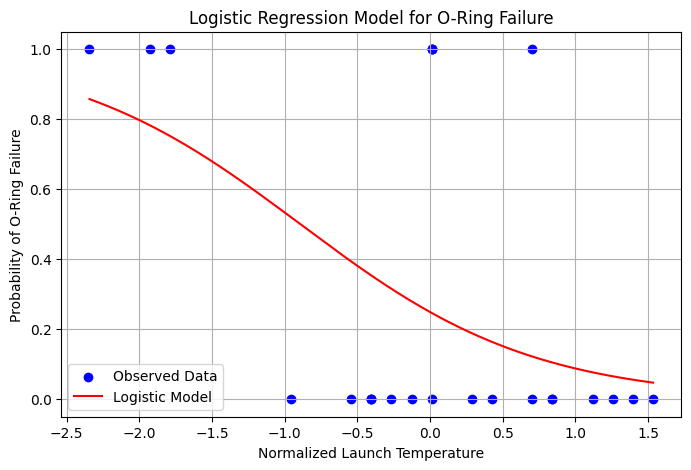

In [16]:
# 3. Plot the original data along with the logistic model.
# For plotting, we show the probability curve and the original binary data.
# We will plot the curve with respect to the normalized temperature.
x_plot = np.linspace(min(X), max(X), 300)
z_plot = theta[0] + theta[1] * x_plot
y_plot = sigmoid(z_plot)

plt.figure(figsize=(8,5))
plt.scatter(X, y, label='Observed Data', color='blue')
plt.plot(x_plot, y_plot, label='Logistic Model', color='red')
plt.xlabel('Normalized Launch Temperature')
plt.ylabel('Probability of O-Ring Failure')
plt.title('Logistic Regression Model for O-Ring Failure')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 4. Prediction for Challenger launch (actual temperature = 31°F).
# First, normalize the temperature using training mu and sigma.
challenger_temp = 31.0
challenger_temp_norm = (challenger_temp - mu_temp) / sigma_temp
z_challenger = theta[0] + theta[1] * challenger_temp_norm
p_failure = sigmoid(z_challenger)
print(f"\nAt Challenger launch temperature = {challenger_temp}°F (normalized: {challenger_temp_norm:.4f}),")
print(f"predicted probability of O-ring failure = {p_failure:.4f}")

# Brief discussion:
print("\nDiscussion:")
print("According to our logistic regression model, the probability of O-ring failure at "
      f"{challenger_temp}°F is {p_failure:.2%}. "
      "If this probability is high, engineers could argue that the low temperature significantly "
      "increased the risk of failure. However, if the probability is low, it might be harder to "
      "convince decision-makers. The actual decision would depend on how the predicted risk compares "
      "to acceptable safety thresholds.")


At Challenger launch temperature = 31.0°F (normalized: -5.3885),
predicted probability of O-ring failure = 0.9962

Discussion:
According to our logistic regression model, the probability of O-ring failure at 31.0°F is 99.62%. If this probability is high, engineers could argue that the low temperature significantly increased the risk of failure. However, if the probability is low, it might be harder to convince decision-makers. The actual decision would depend on how the predicted risk compares to acceptable safety thresholds.
